# 1. 데이터 선정

코로나19가 근 2년간 우리의 삶을 많이 바꾸어 놓았다. 백신에 대한 소식도 이제 슬슬 들려오고, 곧 예전의 일상으로 돌아갈 수 있을까 하는 기대감이 점점 커지고 있다. 하루라도 빨리 마스크를 벗는 날을 기대하면서.. 이번 프로젝트에서 정한 주제는 딥러닝 모델을 통해 코로나19 감염, 정상, 바이러스성폐렴 X-ray 세 종류의 사진을 구분하는 분류 문제이다. 

약 3주동안 딥러닝을 속성(?!)으로 배웠는데, 사실 아직까지 개념은 커녕 코드를 짜기까지에는 너무 무리가 있었다. 프로젝트를 어떻게 수행해야하나.. 고민을 꽤 많이 했다. 물론 해보고 싶은 것은 있었으나 나의 능력 한계..로 인해 시도조차 하기 힘든게 현실이었다. 

이런 이유로 다른 사람들이 미리 구현해 놓은 코드를 참고하여 실행해보는 쪽으로 한번 프로젝트를 시도해 보았다. 코드를 눈으로 보는 것이랑 복붙이라도 직접 실행해 보는 것이랑은 코드를 이해하는 것에 있어서 차이가 꽤 크기 때문이다. 내가 내 손으로 직접 짜보진 못했지만 이렇게 다른 사람이 미리 구현해 놓은 모델을 돌려봄으로서 딥러닝에 대해서 더 이해할 수 있는 계기가 될 수 있는 프로젝트로 수행하고자 하였다.



------------------------
### 데이터 불러오기

In [1]:
#라이브러리 불러오기
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from PIL import Image
from tqdm import tqdm
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras import applications
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras import optimizers
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

참고
https://www.kaggle.com/pratyushmohit/covid-19-classification-using-chest-x-rays

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
base_dir = '/content/drive/MyDrive/archive_covid19/Covid19-dataset'

train_dir = os.path.join(base_dir, 'train')

test_dir = os.path.join(base_dir, 'test')

In [4]:
covid_images = [os.path.join(train_dir, 'Covid', path) for path in os.listdir(train_dir + '/Covid')]
normal_images = [os.path.join(train_dir, 'Normal', path) for path in os.listdir(train_dir + '/Normal')]
viral_pneumonia_images = [os.path.join(train_dir, 'Viral Pneumonia', path) for path in os.listdir(train_dir + '/Viral Pneumonia')]

In [5]:
image1 = Image.open(covid_images[0])
image2 = Image.open(normal_images[0])
image3 = Image.open(viral_pneumonia_images[1])

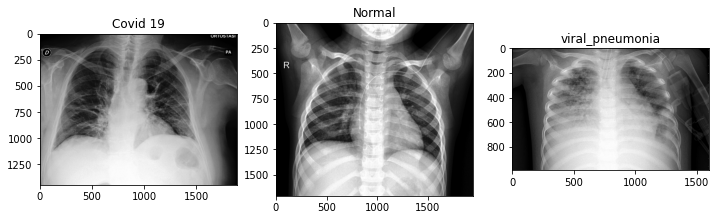

In [6]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.imshow(np.array(image1))
plt.title('Covid 19') 

plt.subplot(1, 3, 2)
plt.imshow(np.array(image2))
plt.title('Normal') 

plt.subplot(1, 3, 3)
plt.imshow(np.array(image3))
plt.title('viral_pneumonia')
plt.show()

In [7]:
#normalize the data
train_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [8]:
#baseline model을 위해 아무런 augmentation없이 이미지를 generating 합니다.
img_width, img_height = 224, 224
batch_size = 8

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


In [9]:
#checking the class counts
from collections import Counter
print("The individual class count in train set is ", Counter(train_generator.classes))
print("The individual class count in test set is ", Counter(test_generator.classes))

The individual class count in train set is  Counter({0: 111, 1: 70, 2: 70})
The individual class count in test set is  Counter({0: 26, 1: 20, 2: 20})


----------------
# 2. 모델

참조
https://www.kaggle.com/shri0007j/covid-19-image-classification

In [10]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)

# model = Sequential()
# model.add(layers.Input(shape = train_generator.image_shape))
# model.add(layers.Conv2D(16, 3, padding ='same', activation = 'relu'))
# model.add(layers.Dropout(0.1))#
# model.add(layers.MaxPooling2D())
# model.add(layers.Dropout(0.2))#
# model.add(layers.Conv2D(32, 3, padding = 'same', activation = 'relu'))
# model.add(layers.MaxPooling2D())
# model.add(layers.Flatten())
# model.add(layers.Dense(128,activation = 'relu'))#
# model.add(layers.Dense(3, activation = 'softmax'))

In [11]:
#ResNet50으로 베이스 모델을 만들었다.

base_model = tf.keras.applications.resnet.ResNet50(weights='imagenet', include_top=False)
global_avg_pooling = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(3, activation='softmax')(global_avg_pooling)

model = tf.keras.Model(inputs=base_model.input, outputs=output)
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9, decay=0.01)

94773248/94765736 [==============================] - 1s 0us/step


In [12]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [13]:
history = model.fit(train_generator, epochs=10, validation_data=test_generator, verbose=1)

Epoch 1/10
32/32 [==============================] - 170s 4s/step - loss: 0.6166 - accuracy: 0.7331 - val_loss: 1.1253 - val_accuracy: 0.3939
Epoch 2/10
32/32 [==============================] - 12s 379ms/step - loss: 0.1307 - accuracy: 0.9602 - val_loss: 1.2795 - val_accuracy: 0.3939
Epoch 3/10
32/32 [==============================] - 12s 382ms/step - loss: 0.0504 - accuracy: 0.9880 - val_loss: 1.5710 - val_accuracy: 0.3939
Epoch 4/10
32/32 [==============================] - 12s 390ms/step - loss: 0.0340 - accuracy: 0.9960 - val_loss: 2.2112 - val_accuracy: 0.3939
Epoch 5/10
32/32 [==============================] - 12s 376ms/step - loss: 0.0261 - accuracy: 0.9960 - val_loss: 2.6744 - val_accuracy: 0.3939
Epoch 6/10
32/32 [==============================] - 12s 381ms/step - loss: 0.0195 - accuracy: 0.9960 - val_loss: 3.0400 - val_accuracy: 0.3939
Epoch 7/10
32/32 [==============================] - 12s 383ms/step - loss: 0.0378 - accuracy: 0.9880 - val_loss: 3.2772 - val_accuracy: 0.3939
E

Base model에서 loss와 accuracy를 epoch에 따라 계산한 것을 꺾은선 그래프로 나타냈다.

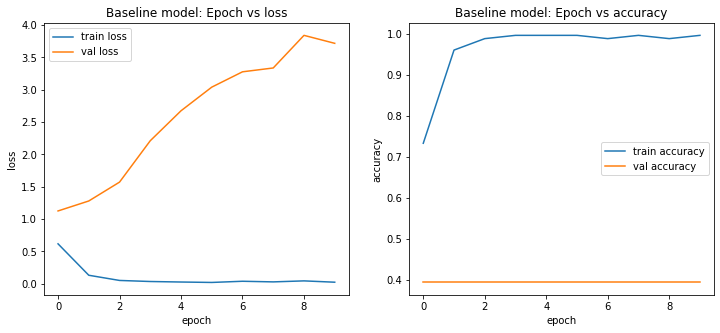

In [14]:
#now lets plot epoch vs loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(10), history.history['loss'], label='train loss')
plt.plot(range(10), history.history['val_loss'], label='val loss')
plt.title('Baseline model: Epoch vs loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(10), history.history['accuracy'], label='train accuracy')
plt.plot(range(10), history.history['val_accuracy'], label='val accuracy')
plt.title('Baseline model: Epoch vs accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

과적합이 되어 있음을 알 수 있다. 정확도를 보면 train accuracy에 비해 val_accuracy가 현저히 낮음을 확인할 수 있다.

In [15]:
#try to add dropout layer for regularization
base_model = tf.keras.applications.resnet.ResNet50(weights='imagenet', include_top=False)
global_avg_pooling = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
dropout = tf.keras.layers.Dropout(rate=0.5)(global_avg_pooling) #added dropout
output = tf.keras.layers.Dense(3, activation='softmax')(dropout)
model = tf.keras.Model(inputs=base_model.input, outputs=output)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

In [16]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [17]:
history = model.fit(train_generator, epochs=10, validation_data=test_generator, verbose=1)

Epoch 1/10
32/32 [==============================] - 18s 414ms/step - loss: 0.8961 - accuracy: 0.7331 - val_loss: 4143.9146 - val_accuracy: 0.3939
Epoch 2/10
32/32 [==============================] - 12s 379ms/step - loss: 0.5841 - accuracy: 0.8207 - val_loss: 5881.3511 - val_accuracy: 0.3939
Epoch 3/10
32/32 [==============================] - 12s 377ms/step - loss: 0.6338 - accuracy: 0.8088 - val_loss: 44.9229 - val_accuracy: 0.3030
Epoch 4/10
32/32 [==============================] - 12s 377ms/step - loss: 0.3825 - accuracy: 0.8805 - val_loss: 57.7485 - val_accuracy: 0.3939
Epoch 5/10
32/32 [==============================] - 12s 377ms/step - loss: 0.2207 - accuracy: 0.9363 - val_loss: 125.1092 - val_accuracy: 0.3939
Epoch 6/10
32/32 [==============================] - 12s 387ms/step - loss: 0.2329 - accuracy: 0.9044 - val_loss: 14.8084 - val_accuracy: 0.3939
Epoch 7/10
32/32 [==============================] - 12s 385ms/step - loss: 0.2172 - accuracy: 0.9323 - val_loss: 1.0962 - val_accur

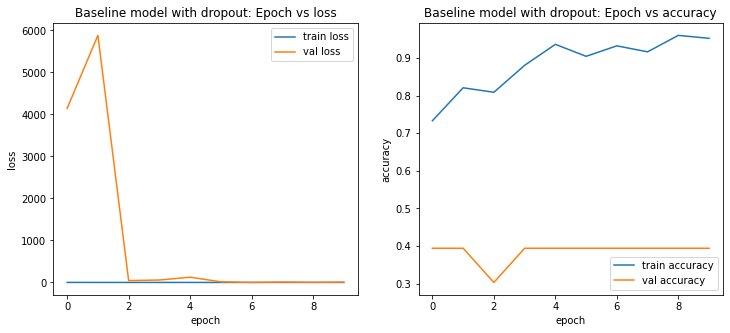

In [18]:
#plotting epoch vs loss and accuracy again
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(10), history.history['loss'], label='train loss')
plt.plot(range(10), history.history['val_loss'], label='val loss')
plt.title('Baseline model with dropout: Epoch vs loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(10), history.history['accuracy'], label='train accuracy')
plt.plot(range(10), history.history['val_accuracy'], label='val accuracy')
plt.title('Baseline model with dropout: Epoch vs accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

dropout을 추가했더니 base model보다는 좀 더 나은 성능을 보여준다. 하지만 여전히 과적합이므로 데이터 증강을 통해 train data 사이즈를 좀 더 늘려서 학습시켜 볼 것이다.

In [19]:
#performing data augmentation
train_datagen = ImageDataGenerator(rescale=1. / 255, 
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [20]:
#generating images with augmentation for the model
img_width, img_height = 224, 224
batch_size = 8

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


In [21]:
x, y = next(train_generator)

In [22]:
x.shape

(8, 224, 224, 3)

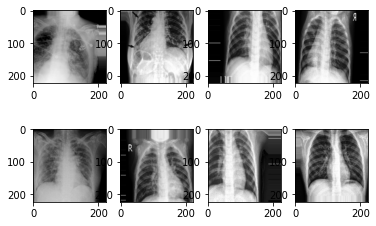

In [23]:
for i, j in zip(range(1,9), range(0,8)):
    plt.subplot(2, 4, i)
    plt.imshow(x[j])

In [24]:
base_model = tf.keras.applications.resnet.ResNet50(weights='imagenet', include_top=False)
global_avg_pooling = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
dropout = tf.keras.layers.Dropout(rate=0.5)(global_avg_pooling) #added dropout
output = tf.keras.layers.Dense(3, activation='softmax')(dropout)
model = tf.keras.Model(inputs=base_model.input, outputs=output)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

In [25]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [26]:
history = model.fit(train_generator, epochs=60, validation_data=test_generator, verbose=1)

Epoch 1/60
32/32 [==============================] - 20s 495ms/step - loss: 1.1490 - accuracy: 0.4900 - val_loss: 1.1235 - val_accuracy: 0.3939
Epoch 2/60
32/32 [==============================] - 15s 453ms/step - loss: 0.8680 - accuracy: 0.6295 - val_loss: 1.0920 - val_accuracy: 0.3939
Epoch 3/60
32/32 [==============================] - 14s 449ms/step - loss: 0.6438 - accuracy: 0.7251 - val_loss: 1.3077 - val_accuracy: 0.3939
Epoch 4/60
32/32 [==============================] - 14s 449ms/step - loss: 0.5311 - accuracy: 0.7849 - val_loss: 1.5055 - val_accuracy: 0.3939
Epoch 5/60
32/32 [==============================] - 14s 450ms/step - loss: 0.3845 - accuracy: 0.8526 - val_loss: 1.7232 - val_accuracy: 0.3939
Epoch 6/60
32/32 [==============================] - 15s 445ms/step - loss: 0.3604 - accuracy: 0.8765 - val_loss: 1.9673 - val_accuracy: 0.3939
Epoch 7/60
32/32 [==============================] - 14s 451ms/step - loss: 0.3639 - accuracy: 0.8327 - val_loss: 2.2463 - val_accuracy: 0.3939

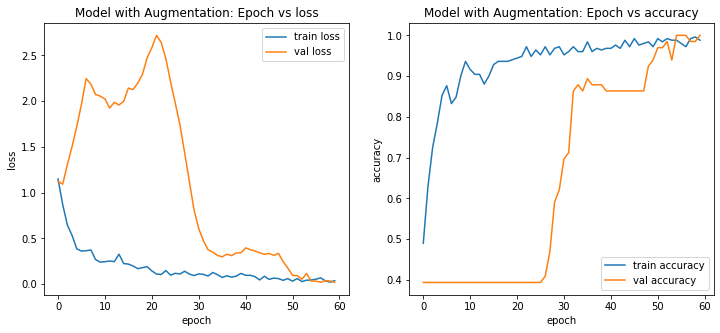

In [27]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(60), history.history['loss'], label='train loss')
plt.plot(range(60), history.history['val_loss'], label='val loss')
plt.title('Model with Augmentation: Epoch vs loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(60), history.history['accuracy'], label='train accuracy')
plt.plot(range(60), history.history['val_accuracy'], label='val accuracy')
plt.title('Model with Augmentation: Epoch vs accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

epoch를 60으로 설정해서 모델을 돌려 본 결과 validation 데이터에서도 높은 정확도의 결과를 얻었다. 

이제 이 모델로 confusion matrix와 F1 점수도 확인해 보겠다.

In [28]:
all_batches = []
count = 1
for batch in tqdm(test_generator):
    all_batches.append(batch)
    count = count + 1
    if count == 33:
        break

31it [00:04,  6.36it/s]


In [29]:
len(all_batches)

32

In [30]:
all_y_hats = []
all_y = []
for X, y in all_batches:
    y_hat = model.predict(X)
    y_hat = np.argmax(y_hat, 1)
    all_y_hats.extend(list(y_hat))
    all_y.extend(list(np.argmax(y, 1)))

In [31]:
print(classification_report(all_y, all_y_hats))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        92
           1       1.00      1.00      1.00        74
           2       1.00      1.00      1.00        72

    accuracy                           1.00       238
   macro avg       1.00      1.00      1.00       238
weighted avg       1.00      1.00      1.00       238



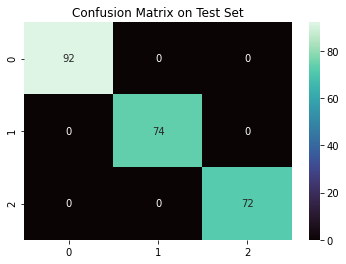

In [32]:
sns.heatmap(confusion_matrix(all_y, all_y_hats), annot=True, cmap='mako')
plt.title('Confusion Matrix on Test Set')
plt.show()

In [ ]:
model.summary()

# 3. 결과 확인

In [34]:
from tensorflow import argmax
from tensorflow import expand_dims
from matplotlib import pyplot as plt


#Take matplotlib frame and remove axes.
def clean_plot(plot):
    plot.axes.get_xaxis().set_visible(False)
    plot.axes.get_yaxis().set_visible(False)

#Dict mapping from class numbers to string labels:
class_names = {
        0: "Covid",
        1: "Normal",
        2: "Pneumonia"
    }

In [35]:
#Loads a sample batch of data
sample_batch_input, sample_labels = test_generator.next()
    
#Grabs the first five images
sample_batch_input = sample_batch_input[:5]
sample_labels = sample_labels[:5]

#Makes predictions using model.predict(x)
sample_predictions = model.predict(sample_batch_input)

X_ray0
	Model prediction: [5.7400612e-08 9.9999726e-01 2.7794470e-06]
	True label: Normal (1)
	Correct: True


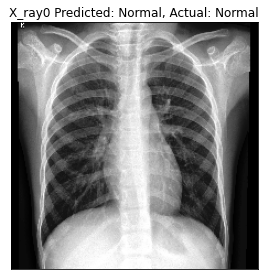

X_ray1
	Model prediction: [8.2256767e-05 3.3964636e-04 9.9957806e-01]
	True label: Pneumonia (2)
	Correct: True


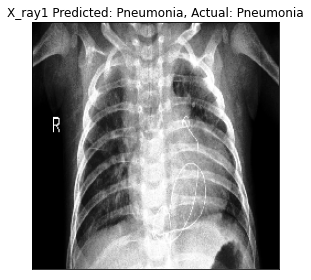

X_ray2
	Model prediction: [1.1088893e-05 9.9692652e-03 9.9001968e-01]
	True label: Pneumonia (2)
	Correct: True


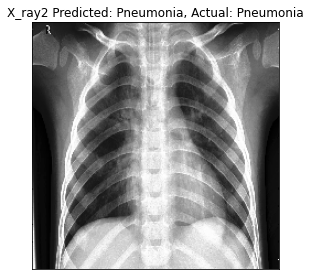

X_ray3
	Model prediction: [5.1468987e-06 2.7317303e-04 9.9972171e-01]
	True label: Pneumonia (2)
	Correct: True


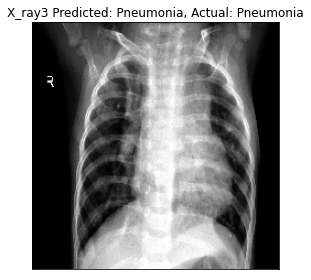

X_ray4
	Model prediction: [9.9820197e-01 1.6983533e-03 9.9665616e-05]
	True label: Covid (0)
	Correct: True


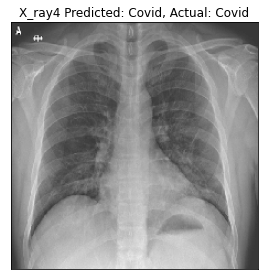

<Figure size 432x288 with 0 Axes>

In [36]:
#Iterate of images, predictions, and true labels
for i, (image, prediction, label) in enumerate(zip(sample_batch_input, sample_predictions, sample_labels)):

    image_name = "X_ray{}".format(i)

    #Gets predicted class with highest probability
    predicted_class = argmax(prediction).numpy()

    #Gets correct label
    actual_class = argmax(label).numpy()

    print(image_name)
    print("\tModel prediction: {}".format(prediction))
    print("\tTrue label: {} ({})".format(class_names[actual_class], actual_class))
    print("\tCorrect:", predicted_class == actual_class)

    #Saves image file using matplotlib
    sample_image = image
    clean_plot(plt.imshow(
    sample_image[:, :, 0],
    cmap = "gray"
        ))
    plt.title(image_name + " Predicted: {}, Actual: {}".format(class_names[predicted_class], class_names[actual_class]))
    plt.tight_layout()
    plt.show()
    plt.clf()